In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

from hmg import HBV1D012A


In [12]:
def NSE(sim_dis, obs_dis):
    # obs are the "true" values, sim is our model output
    mean_obs_dis = np.mean(obs_dis)
    return 1 - (np.sum([(obs_dis[i] - sim_dis[i])**2 for i in range(len(sim_dis))])) / (np.sum([(obs_dis[i] - mean_obs_dis)**2 for i in range(len(sim_dis))]))

def LnNSE(sim_dis, obs_dis):
    #! how to penalize log(0)?
    #! - penalty * (2 + np.random.random())
    raise ValueError("Not implemented yet")

def KGE(sim_dis, obs_dis):
    raise ValueError("Not implemented yet")


def objective_function(prms, diso, modl_objt, efficieny_metric, parameter_in_optimization = [], obj_values= []):

    allowed_metrics = {NSE, LnNSE, KGE}
    if efficieny_metric not in allowed_metrics:
        raise ValueError(f"efficieny_metric must be one of {allowed_metrics}")

    modl_objt.set_parameters(prms)
    modl_objt.set_optimization_flag(0)

    # Run the model for the given inputs, constants and parameters.
    modl_objt.run_model()
    diss = modl_objt.get_discharge()

    # NSE calculation
    efficiency_value = efficieny_metric(sim_dis=diss, obs_dis=diso)
    # print(f"NSE: {NSE_value}")

    OBJ_value = 1 - efficiency_value
    # print(f"OBJ: {OBJ_value}")

    parameter_in_optimization.append(prms.copy())
    obj_values.append(OBJ_value)
    return OBJ_value

def setup_object_with_data():
    main_dir = Path(r'/Users/elias/Desktop/HWS24/MMUQ Seminar/time_series__24163005')
    os.chdir(main_dir)
    inp_dfe = pd.read_csv(r'time_series___24163005.csv', sep=';', index_col=0)
    inp_dfe.index = pd.to_datetime(inp_dfe.index, format='%Y-%m-%d-%H')
    cca_srs = pd.read_csv(r'area___24163005.csv', sep=';', index_col=0)
    ccaa = cca_srs.values[0, 0]
    tems = inp_dfe.loc[:, 'tavg__ref'].values  # Temperature.
    ppts = inp_dfe.loc[:, 'pptn__ref'].values  # Preciptiation.
    pets = inp_dfe.loc[:, 'petn__ref'].values  # PET.
    modl_objt = HBV1D012A()
    tsps = tems.shape[0]  # Number of time steps.
    dslr = ccaa / (3600 * 1000)  # For daily res. multiply denominator with 24.
    modl_objt.set_inputs(tems, ppts, pets)
    modl_objt.set_outputs(tsps)
    modl_objt.set_discharge_scaler(dslr)
    return modl_objt

def get_diso():
    main_dir = Path(r'/Users/elias/Desktop/HWS24/MMUQ Seminar/time_series__24163005')
    os.chdir(main_dir)
    inp_dfe = pd.read_csv(r'time_series___24163005.csv', sep=';', index_col=0)
    inp_dfe.index = pd.to_datetime(inp_dfe.index, format='%Y-%m-%d-%H')
    diso = inp_dfe.loc[:, 'diso__ref'].values  # Observed discharge.
    return diso

In [3]:
bounds = {
    # Snow.
    'snw_dth': (0.0, 10.0), # Initial depth [L].
    'snw_ast': (-1.0, 1.0), # Air snow TEM [K].
    'snw_amt': (0.0, 2.0), # Air melt TEM [K].
    'snw_amf': (0.0, 2.0), # Air melt factor [L/TK].
    'snw_pmf': (0.0, 2.0), # PPT melt factor [L/LTK].

    # Soils.
    'sl0_mse': (0.0, 1e+2), # Soil 0 initial depth [L].
    'sl1_mse': (0.0, 2e+2), # Soil 1 initial depth [L].

    # Soil 0.
    'sl0_fcy': (5.0, 4e+1), # Field capacity [L].
    'sl0_bt0': (1.0, 6.0), # Beta [-].

    # Soil 1.
    'sl1_pwp': (1.0, 2e+2), # PWP [L].
    'sl1_fcy': (1e+2, 4e+2), # Field capacity [L].
    'sl1_bt0': (1.0, 3.0), # Beta [-].

    # Routing reservoirs.
    'urr_dth': (0.0, 2e+1), # URR initial depth [L].
    'lrr_dth': (0.0, 5.0), # LRR initial depth [L].

    # Upper reservoir.
    'urr_rsr': (0.0, 1.0), # Runoff split ratio [-].
    'urr_tdh': (0.0, 1e+2), # Threshold depth [L].
    'urr_tdr': (0.0, 1.0), # Threshold DIS const. [1/T].
    'urr_cst': (1e-4, 1.0), # RNF const. [1/T].
    'urr_dro': (1.0, 1.0), # DIS ratio [-].
    'urr_ulc': (0.0, 1.0), # URR-to-LRR const. [1/T].

    # Lower reservoir.
    'lrr_tdh': (5e+2, 1e+4), # Threshold depth [L].
    'lrr_cst': (0.0, 1.0), # Runoff const. [1/T].
    'lrr_dro': (0.0, 1.0) # Discharge ratio [-].
}

In [4]:
diso = get_diso()
modl_objt = setup_object_with_data()

parameter_in_optimization = []
obj_values = []

result = differential_evolution(objective_function, list(bounds.values()), polish=False, args=(diso, modl_objt, NSE, parameter_in_optimization, obj_values))

parameter_in_optimization = np.array(parameter_in_optimization)
obj_values = np.array(obj_values)

print(f"result.x: {result.x}")
print(f"result.fun: {result.fun}")

opt_prms = result.x

Model runtime: 2.05E-02 seconds.
Model runtime: 2.07E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.03E-02 seconds.
Model runtime: 2.03E-02 seconds.
Model runtime: 2.05E-02 seconds.
Model runtime: 2.05E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 1.88E-02 seconds.
Model runtime: 2.06E-02 seconds.
Model runtime: 2.06E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.11E-02 seconds.
Model runtime: 4.30E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.05E-02 seconds.
Model runtime: 2.06E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.05E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.06E-02 seconds.
Model runtime: 1.90E-02 seconds.
Model runtime: 2.05E-02 seconds.
Model runtime: 2.06E-02 seconds.
Model runtime: 2.07E-02 seconds.
Model runtime: 2.03E-02 seconds.
Model runtime: 2.06E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runt

In [5]:

opt_prms = np.array([6.70180268e-01,
    -4.73635541e-01,
    1.39573083e+00,
    2.85948067e-01,
    2.96108258e-01,
    9.06437515e+01,
    1.06834473e+01,
    5.04459911e+00,
    1.09250502e+00,
    1.90613268e+02,
    1.55454530e+02,
    1.73108194e+00,
    4.43894918e-01,
    5.25192818e-01,
    9.90426386e-01,
    2.82355194e+01,
    8.14094054e-01,
    1.03801474e-04,
    1.00000000e+00,
    1.96578290e-01,
    7.39459909e+02,
    8.81377843e-03,
    9.99256261e-01], dtype=np.float32)

In [6]:
def sample_full_range(param_name, size):
    return np.random.uniform(low=bounds[param_name][0], high=bounds[param_name][1], size=size)

def sample_narrow_range(param_name, size):
    opt_param_value = opt_prms[list(bounds.keys()).index(param_name)]
    range_factor = 0.2
    if opt_param_value == 0:
        print("For the parameter: ", param_name, " the optimal value is 0")
        return None
    elif opt_param_value < 0:
        low = np.max([bounds[param_name][0], opt_param_value * (1 + range_factor)])
        high = np.min([bounds[param_name][1], opt_param_value * (1 - range_factor)]) 
    else:
        low = np.max([bounds[param_name][0], opt_param_value * (1 - range_factor)])
        high = np.min([bounds[param_name][1], opt_param_value * (1 + range_factor)])
    return np.random.uniform(low=low, high=high, size=size)

In [42]:
def algorithm(mc_size, metric, narrow_range = False):
    #! not sure with the name of the algorithm
    p = len(bounds.keys())
    A = np.zeros((mc_size, p))
    B = np.zeros((mc_size, p))
    for param_index, param_name in enumerate(bounds.keys()):
        if narrow_range:
            A[:, param_index] = sample_narrow_range(param_name, mc_size)
            B[:, param_index] = sample_narrow_range(param_name, mc_size)
        else:
            A[:, param_index] = sample_full_range(param_name, mc_size)
            B[:, param_index] = sample_full_range(param_name, mc_size)
    y_A = np.zeros(mc_size)
    y_B = np.zeros(mc_size)
    for m in range(mc_size):
        y_A[m] = objective_function(A[m], diso, modl_objt, metric)
        y_B[m] = objective_function(B[m], diso, modl_objt, metric)
    
    print(f"y_A: {y_A}")

    f_0_squared = np.mean(y_A) * np.mean(y_B)

    S_single = np.zeros(p)
    S_total = np.zeros(p)
    
    for i in range(p):
        C_i = np.zeros((mc_size, p))
        for param_index, param_name in enumerate(bounds.keys()):
            if param_index == i:
                C_i[:, param_index] = A[:, param_index]
            else:
                C_i[:, param_index] = B[:, param_index]
        
        y_C_i = np.zeros(mc_size)
        for m in range(mc_size):
            y_C_i[m] = objective_function(C_i[m], diso, modl_objt, metric)
        
        denominator = 1/mc_size * np.sum([y_A[j]**2 for j in range(mc_size)]) - f_0_squared
        S_single[i] = (1/mc_size * np.sum([y_A[j] * y_C_i[j] for j in range(mc_size)]) - f_0_squared) / denominator
        S_total[i] = 1 - ((1/mc_size * np.sum([y_B[j] * y_C_i[j] for j in range(mc_size)]) - f_0_squared) / denominator)

    return S_single, S_total
        

Model runtime: 2.39E-02 seconds.
Model runtime: 2.27E-02 seconds.
Model runtime: 2.59E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.11E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.02E-02 seconds.
Model runtime: 2.03E-02 seconds.
Model runtime: 2.09E-02 seconds.
Model runtime: 2.24E-02 seconds.
Model runtime: 2.05E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.10E-02 seconds.
Model runtime: 2.07E-02 seconds.
Model runtime: 2.10E-02 seconds.
Model runtime: 2.10E-02 seconds.
Model runtime: 2.09E-02 seconds.
Model runtime: 2.08E-02 seconds.
Model runtime: 2.12E-02 seconds.
Model runtime: 2.05E-02 seconds.
Model runtime: 2.14E-02 seconds.
Model runtime: 2.15E-02 seconds.
Model runtime: 2.18E-02 seconds.
Model runtime: 2.11E-02 seconds.
Model runtime: 2.08E-02 seconds.
Model runtime: 2.05E-02 seconds.
Model runtime: 1.86E-02 seconds.
Model runtime: 2.06E-02 seconds.
Model runt

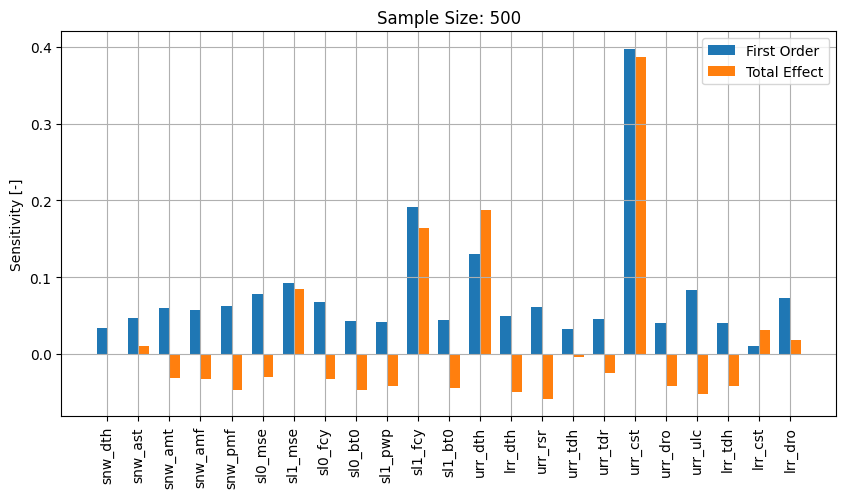

In [ ]:
mc_size = int(1e4) #! chosse > 1e5
S_single, S_total = algorithm(mc_size, NSE, narrow_range = False)


fig, ax = plt.subplots(figsize=(10, 5))

# Set width for each bar
bar_width = 0.35

ax.bar(np.arange(len(S_single)), S_single, width=bar_width, label='First Order')
ax.bar(np.arange(len(S_single)) + bar_width, S_total, width=bar_width, label='Total Effect')
ax.set_xticks(np.arange(len(S_single)) + bar_width / 2)
ax.set_xticklabels(bounds.keys(), rotation=90)
ax.set_ylabel('Sensitivity [-]')
ax.set_title(f'Sample Size: {mc_size}')
ax.grid(True)
ax.legend()
plt.show()